In [1]:
import pandas as pd
import censusdata
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import glob

%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [2]:
from config import *

In [3]:
#Load states shapefile (for plotting) (https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html under States)

statesShp = geopandas.read_file(dataFolder + "/cb_2018_us_state_500k.zip").to_crs(3857)
statesShp = statesShp[['GEOID', 'STUSPS', 'NAME', 'geometry']]

def plotUS():
    ax = statesShp.plot(figsize=(20, 10))
    ax.axis('equal')
    plt.xlim(-1.5e7, -0.7e7)
    plt.ylim(2.5e6, 7e6)
    return ax

In [4]:
CBSAs = geopandas.read_file(dataFolder + "/tl_2019_us_cbsa.zip").to_crs(3857)
CBSAs = CBSAs[['CBSAFP', 'NAME', 'geometry']]
CBSAs['CBSAFP'] = CBSAs['CBSAFP'].astype(int)
CBSAs.rename(columns={'CBSAFP': 'CBSA'}, inplace=True)

In [5]:
odData = pd.read_pickle(dataFolder + "/od_data_combined20.pkl")
xwalk = pd.read_pickle(dataFolder + "/xwalk_data_combined.pkl")

In [6]:
odData['h_bgrp'] = (odData['h_geocode'] / 10**3).astype(int)
odData['w_bgrp'] = (odData['w_geocode'] / 10**3).astype(int)

In [7]:
bgrpToCbsa = xwalk.groupby('bgrp').first()['cbsa']
bgrpToCbsa = dict(zip(bgrpToCbsa.index, bgrpToCbsa.values)) #Dict is faster for lookup

In [8]:
odData['w_cbsa'] = odData['w_bgrp'].apply(lambda c: bgrpToCbsa[c])
odData['h_cbsa'] = odData['h_bgrp'].apply(lambda c: bgrpToCbsa[c])

In [9]:
workingPop = odData.groupby(['w_cbsa']).sum()[['S000']]
workingPop

,S000
w_cbsa,
10100,19636.0
10140,20310.0
10180,64647.0
10220,18486.0
10300,22383.0
...,...
49700,46420.0
49740,58006.0
49780,30922.0


In [10]:
gdf = pd.merge(CBSAs, workingPop, left_on='CBSA', right_on='w_cbsa')
gdf

,CBSA,NAME,geometry,S000
0,12020,"Athens-Clarke County, GA","POLYGON ((-9299339.399 4024225.385, -9298722.4...",83811.0
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","POLYGON ((-9499808.416 3982318.514, -9499830.0...",2622265.0
2,12100,"Atlantic City-Hammonton, NJ","POLYGON ((-8333014.948 4782122.394, -8333009.7...",103595.0
3,12120,"Atmore, AL","POLYGON ((-9753303.463 3638074.432, -9753303.2...",10510.0
4,12140,"Auburn, IN","POLYGON ((-9483635.192 5068556.085, -9483636.4...",18680.0
...,...,...,...,...
921,49060,"Winfield, KS","POLYGON ((-10814782.844 4481524.994, -10814783...",12484.0
922,49080,"Winnemucca, NV","POLYGON ((-13233024.775 5006594.818, -13233215...",6936.0
923,49100,"Winona, MN","POLYGON ((-10250133.062 5468589.383, -10250142...",20311.0
924,49180,"Winston-Salem, NC","POLYGON ((-8955841.577 4336663.225, -8955841.5...",257183.0


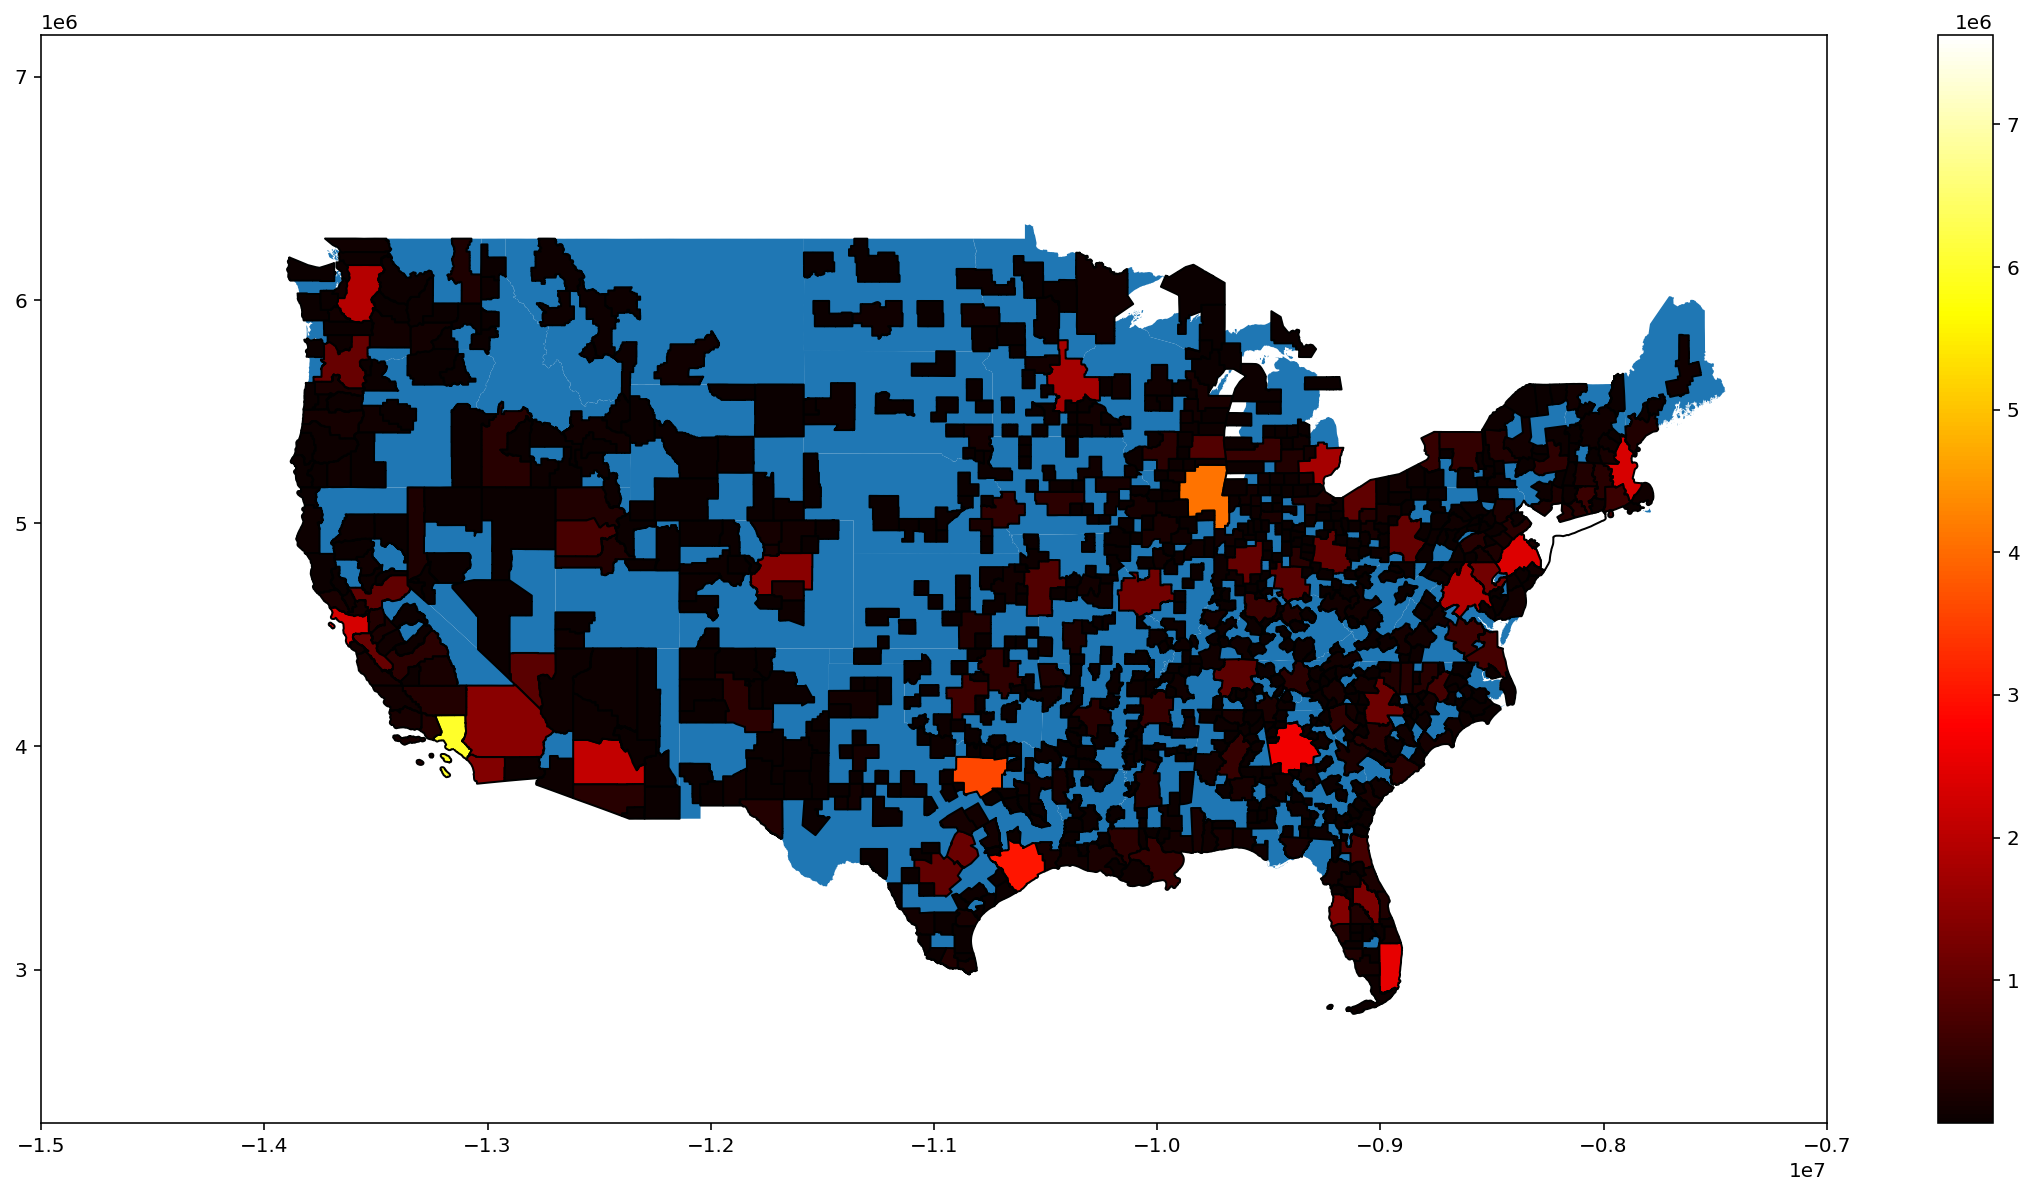

In [11]:
ax = plotUS()
gdf.plot(ax=ax, column='S000', edgecolor="black", linewidth=1, legend=True, cmap="hot");